In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt,rotate_rt_ne
from matplotlib.ticker import MultipleLocator
from obspy import read, read_inventory, Stream, Trace, Catalog
import numpy as np
from obspy.io.sac.sacpz import attach_paz
from obspy.signal.filter import envelope
import pandas as pd
import os,glob
import warnings
warnings.filterwarnings("ignore")
model = TauPyModel(model="iasp91")
client = Client("IRIS")
plt.rcParams['font.sans-serif']='Times New Roman'

In [2]:
# eventlist = ['201507070510','201505290700','201505240453','201502271345','201503172212','201502200425',
#             '201412211134','201411150231','201403131706']
eventlist = ['20140302201122']
cat = Catalog()
for event in eventlist:
    eve_time = UTCDateTime(event)
    eqevent = client.get_events(starttime=eve_time-5, endtime=eve_time+10*60,minmagnitude =6.4)
    cat+=eqevent
    

In [3]:
def checkday(num):
    if len(str(num)) == 1 :
        num = str(0)+str(num)
    return str(num)

In [16]:
network= ['TG','AM']
DATA_DIR = '/Volumes/home/Research/DataBase/00_'
PZ_DIR  =  '/Volumes/home/Research/DataBase/00_PZs'
INFO_DIR = '/Volumes/home/Research/DataBase/Armenia'
CSV_DIR = '/Volumes/home/Research/STEP/00_check_N'
freqmin=0.05
freqmax=1
xmin=-10; xmax = 20
df = pd.read_csv(INFO_DIR+'/Station_info.csv')

Badstation = ['DDFL','DGRG','LICH','LGD','NAVR','BATM','CANZ','BAUR','GANZ','BKRG','AZMN']
mmm= 5*10**-6
win = 'Pwindow' #'Swindow'

2014-03-02T20:11:22.710000Z
GO ONI exist
ABST
lagtime=0.05(s)
BURN
lagtime=0.39(s)
DMNI
lagtime=0.51(s)
KZRT
lagtime=0.95(s)


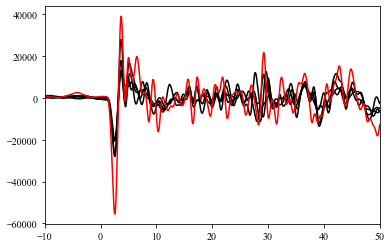

In [27]:
for i in range(0,1):#len(cat)):
    eq_time = cat[i].origins[0].time
    print(eq_time)
    eq_lon = cat[i].origins[0].longitude
    eq_lat = cat[i].origins[0].latitude
    depth  = cat[i].origins[0].depth/1000
    mag    = cat[i].magnitudes[0].mag
    mag_type = cat[i].magnitudes[0].magnitude_type

#     try:
    inv1 = client.get_stations(network="GO", station='ONI', channel="HH?",
                                    starttime=eq_time,endtime=eq_time+30*60)

    ori_st = client.get_waveforms('GO','ONI','*','HH?',eq_time,eq_time+30*60,attach_response=True)
    print('GO ONI exist')
    st = ori_st.copy()
#     st.remove_response(pre_filt =  [0.001,0.005,45,50], output="VEL",water_level=60)
    st.detrend('linear')
    st.detrend('demean')
    st.taper(0.05,type='cosine')
    st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)


    st_lat = inv1[0][0].latitude
    st_lon = inv1[0][0].longitude
    dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
    deg = kilometer2degrees(dist/1000)
    Arr=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=deg,phase_list=['P','S'])
    ONI_P_arr = Arr[0].time
    ONI_S_arr = Arr[1].time
    ONI_HHE = st.select(component='E')[0].data
    ONI_HHN = st.select(component='N')[0].data
    ONI_HHZ = st.select(component='Z')[0].data
    ONI_HHR,ONI_HHT = rotate_ne_rt(ONI_HHN,ONI_HHE,baz)

    if win == 'Pwindow':
        ONI_times = st.select(component='E')[0].times(reftime=eq_time+ONI_P_arr)
        xmin_ind = np.where(ONI_times==min(ONI_times, key=lambda x:abs(x-(xmin))))[0][0]
        xmax_ind = np.where(ONI_times==min(ONI_times, key=lambda x:abs(x-(xmax))))[0][0]
    elif win == 'Swindow':
        ONI_times = st.select(component='E')[0].times(reftime=eq_time+ONI_S_arr)
        xmin_ind = np.where(ONI_times==min(ONI_times, key=lambda x:abs(x-(xmin))))[0][0]
        xmax_ind = np.where(ONI_times==min(ONI_times, key=lambda x:abs(x-(xmax))))[0][0]

    ONI_Z_window = ONI_HHZ[xmin_ind:xmax_ind]
    #####################################################################################
    yyyy = eq_time.year
    mm = checkday(eq_time.month)
    dd = checkday(eq_time.day)
    hh = checkday(eq_time.hour)
    minn = checkday(eq_time.minute)

    deglist = [];STAlist=[]; BAZlist = []
    for net in network[0:1]:
        NET_DIR = f'{DATA_DIR}{net}'
        NET_PZs = f'{PZ_DIR}/{net}'
        eq_DIR =  f'{NET_DIR}/{yyyy}{mm}{dd}{hh}{minn}'
        if os.path.isdir(eq_DIR):

            for path in sorted(glob.glob(f'{eq_DIR}/*Z')):

                STA = path.rsplit('.',2)[1]

                if STA not in Badstation:

                    ori_st = Stream()
                    st_lat = (df['lat'][ (df['network'] == net ) & (df['station'] == STA) ]).item()
                    st_lon = (df['lon'][ (df['network'] == net ) & (df['station'] == STA) ]).item()

                    dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
                    print(STA)
                    dist = dist/1000
                    deg = kilometer2degrees(dist)
                    Arr=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=deg,phase_list=['P','S'])
                    P_arr = Arr[0].time
                    S_arr = Arr[1].time
                    for datapath in glob.glob(f'{eq_DIR}/*{STA}.HH?'):
                            channel = datapath.rsplit('.',1)[-1]
                            tr4pz = Trace()
                            PZs = glob.glob(f'{NET_PZs}/{STA}/*{STA}_{channel}.txt')
                            if PZs == [] and net == 'TG' :
                                PZs = glob.glob(f'{NET_PZs}/ABST/*ABST_{channel}.txt')
                            elif PZs == [] and net == 'AM':
                                PZs = glob.glob(f'{NET_PZs}/ARZA/*ARZA_{channel}.txt')
#                             attach_paz(tr4pz,PZs[0],tovel=True)
#                             paz = dict(tr4pz.stats.paz)
                            tr = read(datapath,starttime=eq_time, endtime=eq_time+30*60)
#                             tr.simulate(paz_remove=paz,pre_filt=(0.033, 0.034, 45, 50))
                            ori_st += tr

                    st = ori_st.copy()
                    st.merge(fill_value=0)
                    st.detrend('linear')
                    st.detrend('demean')
        #             st.taper(0.05,type='cosine')
                    st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)



                    HHE = st.select(component='E')[0].data
                    HHN = st.select(component='N')[0].data
                    HHZ = st.select(component='Z')[0].data
                    if win == 'Pwindow':
                        times = st[0].times(reftime=eq_time+P_arr)
                        xmin_ind = np.where(times==min(times, key=lambda x:abs(x-(xmin))))[0][0]
                        xmax_ind = np.where(times==min(times, key=lambda x:abs(x-(xmax))))[0][0]
                    elif win == 'Swindow':
                        times = st[0].times(reftime=eq_time+S_arr)
                        xmin_ind = np.where(times==min(times, key=lambda x:abs(x-(xmin))))[0][0]
                        xmax_ind = np.where(times==min(times, key=lambda x:abs(x-(xmax))))[0][0]

                    ori_HHR , ori_HHT    = rotate_ne_rt(HHN,HHE,baz)   
                    ori_R_window = ori_HHR[xmin_ind:xmax_ind]
                    ori_T_window = ori_HHT[xmin_ind:xmax_ind]
                    ori_Z_window = HHZ[xmin_ind:xmax_ind]

###==================================================  
                    nx = len(ONI_Z_window)
                    lags = np.arange(-nx+1 ,nx)
                    ccov = np.correlate(ONI_Z_window - np.mean(ONI_Z_window), ori_Z_window-np.mean(ori_Z_window), mode = 'full')
                    ccor = ccov / ((nx-1)* np.std(ONI_Z_window) * np.std(ori_Z_window))
                    
                    delta= 0.01
                    ccv_X_Z = lags*delta
                    ccv_Y_Z = ccor
                    for i in range(len(lags)):
                        if abs(ccv_Y_Z[i]) == max(abs(ccv_Y_Z)):
                            ccv_y_Z = ccv_Y_Z[i]
                            ccv_x_Z = lags[i]*delta
                            lagtime = lags[i]
                            lagtime_s = ccv_x_Z       
                    print('lagtime=%s(s)' %(lagtime_s))
                    
                    
                    plt.plot(times+lagtime_s,HHZ,'k')
    plt.plot(ONI_times,ONI_HHZ,'r')
    plt.xlim(-10,50)
                    

(-10.0, 50.0)

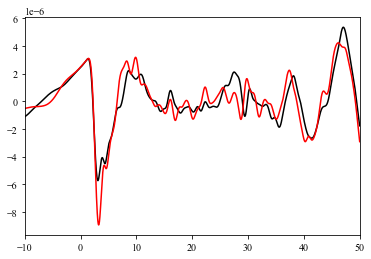

In [20]:
plt.plot(times+lagtime_s,HHZ,'k')
plt.plot(ONI_times,ONI_HHZ,'r')
plt.xlim(-10,50)

# check remove instrument response 
# file: poles and zeros
# TG network

In [59]:
CSV_DIR = '/Volumes/home/Research/STEP/00_remove_IR'

In [63]:
sac = read(f'{CSV_DIR}/ABST_HHZ_vel.sac')
sactime = sac[0].times()
sacdata = sac[0].data


In [65]:
st = read(f'{CSV_DIR}/2014061201122.00.ABST.HHZ')
tr4pz = Trace()
PZs = glob.glob(f'{CSV_DIR}/*.txt')
attach_paz(tr4pz,PZs[0],tovel=True)
paz = dict(tr4pz.stats.paz)
st[0].simulate(paz_remove=paz,pre_filt=(0.033, 0.04, 45, 50))
st.detrend('linear')
st.detrend('demean')
data = st[0].data
time = st[0].times()

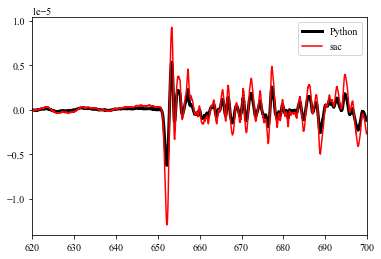

In [66]:
plt.plot(time,data,'k',label='Python',lw=3)
plt.plot(sactime,sacdata,'r',label='sac')
plt.xlim(620,700)
plt.legend()


# IRIS data
# file : response

In [104]:
sac = read(f'{CSV_DIR}/GO.ONI..HHZ.resp_vel.sac') ##GO.ONI..HHZ.resp_disp.sac

sactime = sac[0].times()
sacdata = sac[0].data

# sacdata = sacdata/max(sacdata)

In [105]:
st = read(f'{CSV_DIR}/GO.ONI..HHZ.20140302201122.sac')
inv = read_inventory(f'{CSV_DIR}/RESP_GO_ONI_HHZ.txt')
st.remove_response(inventory=inv,pre_filt=[0.033,0.04,45,50],output="VEL")  ## "DISP"
st.detrend('linear')
st.detrend('demean')
data = st[0].data
time = st[0].times()
# data = data/ max(data)

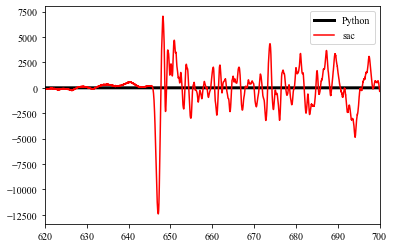

In [106]:
plt.plot(time,data,'k',label='Python',lw=3)
plt.plot(sactime,sacdata,'r',label='sac')
plt.xlim(620,700)
plt.legend()

# IRIS data
# file : paz

In [107]:
sac = read(f'{CSV_DIR}/GO.ONI..HHZ.paz_vel.sac')
sactime = sac[0].times()
sacdata = sac[0].data

In [110]:
st = read(f'{CSV_DIR}/GO.ONI..HHZ.20140302201122.sac')
# tr4pz = Trace()
# PZs = glob.glob(f'{CSV_DIR}/SAC_GO_ONI_HHZ.txt')
# attach_paz(tr4pz,PZs[0],tovel=True)
# paz = dict(tr4pz.stats.paz)
# st.simulate(paz_remove=paz,pre_filt=(0.033, 0.04, 45, 50))
# st.detrend('linear')
# st.detrend('demean')
data = st[0].data
time = st[0].times()

(620.0, 700.0)

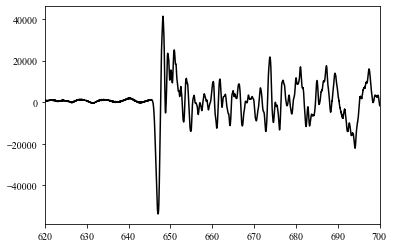

In [114]:
plt.plot(time,data,'k',label='Python',lw=1.5)
# plt.plot(sactime,sacdata,'r',label='sac')

plt.xlim(620,700)
# plt.legend()

# compare response & paz

In [115]:
sac = read(f'{CSV_DIR}/GO.ONI..HHZ.paz_vel.sac') ##GO.ONI..HHZ.resp_disp.sac

sactime = sac[0].times()
sacdata = sac[0].data


In [124]:
st = read(f'{CSV_DIR}/GO.ONI..HHZ.20140302201122.sac')
inv = read_inventory(f'{CSV_DIR}/RESP_GO_ONI_HHZ.txt')
st.remove_response(inventory=inv,pre_filt=[0.033,0.04,45,50],output="VEL")  ## "DISP"
st.detrend('linear')
st.detrend('demean')
resp_data = st[0].data
resp_time = st[0].times()

In [125]:
st = read(f'{CSV_DIR}/GO.ONI..HHZ.20140302201122.sac')
inv = read_inventory(f'{CSV_DIR}/XML_GO_ONI_HHZ.xml')
st.remove_response(inventory=inv,pre_filt=[0.033,0.04,45,50],output="VEL")  ## "DISP"
st.detrend('linear')
st.detrend('demean')
xml_data = st[0].data
xml_time = st[0].times()

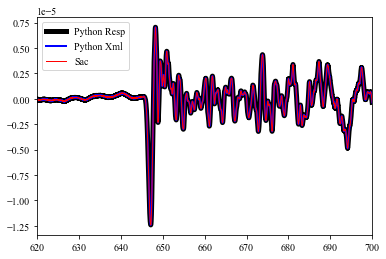

In [129]:
plt.plot(resp_time,resp_data,'k',label='Python Resp',lw=5)
plt.plot(xml_time,xml_data,'b',label='Python Xml',lw=2)
plt.plot(sactime,sacdata,'r',label='Sac',lw=1)

plt.xlim(620,700)
plt.legend()

# pz file & XML file

In [120]:
sac = read(f'{CSV_DIR}/GO.ONI..HHZ.paz_vel.sac') ##GO.ONI..HHZ.resp_disp.sac

sactime = sac[0].times()
sacdata = sac[0].data


In [121]:
st = read(f'{CSV_DIR}/GO.ONI..HHZ.20140302201122.sac')
inv = read_inventory(f'{CSV_DIR}/XML_GO_ONI_HHZ.xml')
st.remove_response(inventory=inv,pre_filt=[0.033,0.04,45,50],output="VEL")  ## "DISP"
st.detrend('linear')
st.detrend('demean')
data = st[0].data
time = st[0].times()

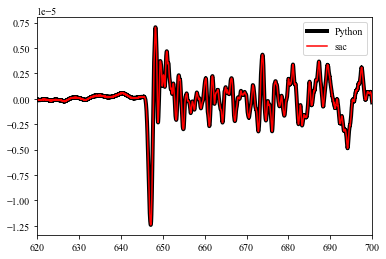

In [122]:
plt.plot(time,data,'k',label='Python',lw=4)
plt.plot(sactime,sacdata,'r',label='sac')

plt.xlim(620,700)
plt.legend()